In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PrepareData import prepare_dataset
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare dataset

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()

/home/simon/Dissertation/Abalone/PrepareData.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']])
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3383, 10) (3383,)
(376, 10) (376,)
(418, 10) (418,)


In [4]:
def plot_predictions(pred, y):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 30, 0.1), np.arange(0, 30, 0.1))

In [5]:
def sum_squared_error(pred, y):
    return np.sum((y - pred)**2)

## Encrypted Linear model

In [106]:
model_lin_weights = np.load('model_lin_weights.npy')

In [107]:
X_test_enc = EA(X_test.values, True)

In [108]:
w = EA(model_lin_weights[0])
b = EA(model_lin_weights[1].reshape(1, -1))

In [109]:
pred = X_test_enc.dot(w) + b
pred.shape

(418, 1)

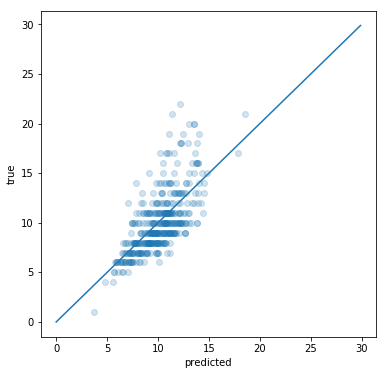

In [110]:
plot_predictions(pred.values().flatten(), y_test)

In [111]:
sse_enc = sum_squared_error(pred.values().flatten(), y_test)
print('SSE encrypted: {}'.format(sse_enc))

SSE encrypted: 2069.4778883855115


In [112]:
pred_clear = np.dot(X_test, model_lin_weights[0]) + model_lin_weights[1]
sse_clear = sum_squared_error(pred_clear.flatten(), y_test)
print('SSE clear: {}'.format(sse_clear))

SSE clear: 2069.4778883855115


## Linear - Batch Normalization

In [6]:
def normalize_weights(w, var, scale):
    return w * scale / np.sqrt(var + 0.001)

In [7]:
def normalize_bias(b, mean, var, shift, scale):
    return (b - mean) * (scale / np.sqrt(var + 0.001)) + shift

In [80]:
norm_weights = np.load('model_norm_weights.npy')

In [81]:
w1, b1, scale, shift, mean, std, w2, b2 = norm_weights

In [82]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [87]:
X_test_enc = EA(X_test.values, True)
w_norm_en = EA(w_norm)
b_norm_en = EA(b_norm)
w2_en = EA(w2)
b2_en = EA(b2.reshape(-1, 1))

In [91]:
layer1_enc = X_test_enc.dot(w_norm_en) + b_norm_en
pred_norm_enc = layer1_enc.dot(w2_en) + b2_en
pred_decrypted = pred_norm_enc.values()

In [92]:
sum_squared_error(pred_decrypted.reshape(-1,), y_test)

2606.9924618704367

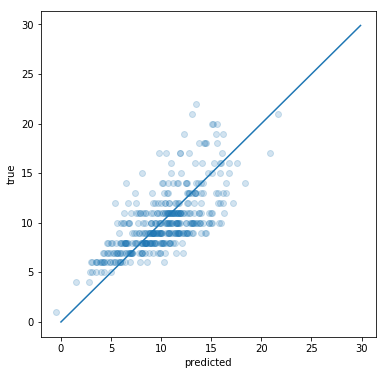

In [93]:
plot_predictions(pred_decrypted.reshape(-1,), y_test)

In [83]:
layer1 = X_test.values.dot(w_norm) + b_norm
pred_norm = layer1.dot(w2) + b2

In [84]:
sum_squared_error(pred_norm.reshape(-1,), y_test)

2606.9924612842833

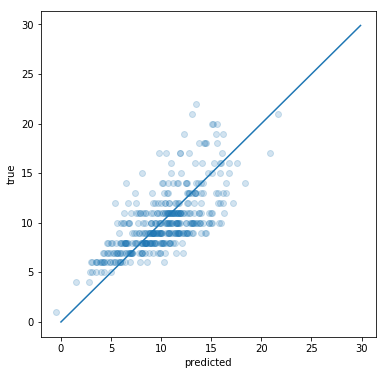

In [94]:
plot_predictions(pred_norm, y_test)

## Sigmoid model - 1 Layer

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
%autoreload 2

In [10]:
sig_weights = np.load('model_sig_weights.npy')

In [11]:
w1, b1, scale, shift, mean, std, w2, b2 = sig_weights

In [12]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale)

In [13]:
X_test_enc = EA(X_test.values, True)

In [14]:
X_test_enc.values()

array([[ 0.88980632,  0.98369189,  0.24621869, ...,  0.        ,
         0.        ,  1.        ],
       [-0.19224127, -0.07237882,  0.12936153, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.63891619,  1.43629362,  1.4147903 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.06620278, -1.07816044, -1.15606724, ...,  0.        ,
         1.        ,  0.        ],
       [-1.60722658, -1.68162942, -1.50663872, ...,  0.        ,
         1.        ,  0.        ],
       [-0.02577241, -0.02208974,  0.01250437, ...,  0.        ,
         1.        ,  0.        ]])

In [15]:
w_norm_enc = EA(w_norm)
b_norm_enc = EA(b_norm.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [16]:
layer1 = X_test_enc.dot(w_norm_enc) + b_norm_enc

MemoryError: std::bad_alloc

In [22]:
layer1.values()

array([[  1.06257561,   2.63176891,  -6.03064548],
       [  2.38607846,  -0.70920222,   2.33750304],
       [  5.61899706,   1.58495686, -11.56404062],
       ...,
       [ -1.09500084,  -1.6092351 ,  -2.92493279],
       [ -1.60889306,  -2.07154837,  -1.99771178],
       [  0.78518812,   0.31067854,   1.35874276]])

In [23]:
layer1_sig = layer1.activate_sigmoid()

In [24]:
layer1_sig.values()

array([[ 7.37146409e-01,  7.36074375e-01,  7.22263955e+01],
       [ 7.95754876e-01,  3.25250414e-01,  6.36571251e+02],
       [-1.81682321e+00,  8.43573031e-01,  3.63603141e+01],
       ...,
       [ 2.54148110e-01,  1.85159903e-01, -8.53602154e+01],
       [ 1.45625305e-01,  1.67157483e-01, -7.06761880e+01],
       [ 6.86346995e-01,  5.80759792e-01,  8.67068211e-02]])

In [25]:
pred_sig = layer1_sig.dot(w2_enc) + b2_enc

In [26]:
pred_sig.values()

array([[-6.36750987e+03],
       [ 5.32785411e+03],
       [-4.53684698e+01],
       [-5.45870097e+04],
       [ 1.93647648e+01],
       [ 9.31565818e+00],
       [ 4.81768532e+04],
       [-1.51996450e+04],
       [-6.28314036e+01],
       [-2.40577684e+02],
       [ 6.51418418e+02],
       [-4.56021044e+04],
       [ 9.61137934e+00],
       [-3.74651086e+04],
       [-1.66310325e+04],
       [ 7.88125305e+01],
       [ 2.42400080e+04],
       [ 4.69744630e+04],
       [-1.38456083e+03],
       [ 7.39539593e+01],
       [-4.66239153e+04],
       [-7.44867710e+02],
       [ 9.50488003e+00],
       [-9.53419820e+02],
       [ 2.64669073e+02],
       [-5.38823688e+02],
       [-5.58942424e+05],
       [-1.22268084e+02],
       [ 5.06556000e+03],
       [-6.06227350e+02],
       [ 4.98443082e+01],
       [ 2.64088622e+03],
       [ 3.48953315e+02],
       [ 2.91987518e+01],
       [-1.27742966e+02],
       [-3.50231714e+02],
       [ 3.91421949e+02],
       [ 1.10261314e+02],
       [-8.7

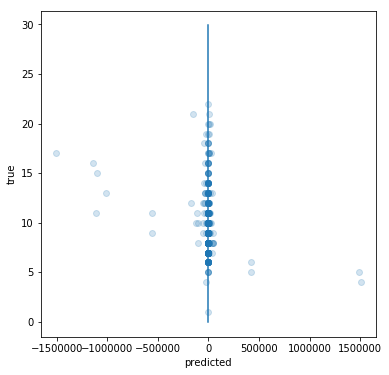

In [27]:
plot_predictions(pred_sig.values().reshape(-1,), y_test)

In [274]:
layer1_clear = X_test.values.dot(w_norm) + b_norm
layer1_sig_clear = sigmoid(layer1_clear)
pred_sig_clear = layer1_sig_clear.dot(w2) + b2

In [120]:
sse_sig_enc = sum_squared_error(pred_sig.values().flatten(), y_test)
print('SSE sigmoid enc: {}'.format(sse_sig_enc))

SSE sigmoid enc: 1.1953515815530873e+40


In [276]:
sse_sig_clear = sum_squared_error(pred_sig_clear.flatten(), y_test)
print('SSE sigmoid clear: {}'.format(sse_sig_clear))

SSE sigmoid clear: 2156.118175473507


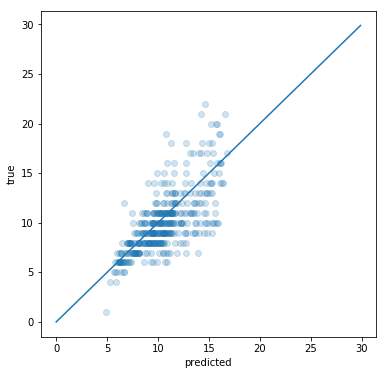

In [278]:
plot_predictions(pred_sig_clear.flatten(), y_test)

## Relu model - 1 Layer

In [279]:
def relu(z):
    return np.maximum(z, 0)

In [280]:
relu_weights = np.load('weights_relu.npy')

In [281]:
w1, b1, scale, shift, mean, std, w2, b2 = relu_weights

In [282]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [283]:
layer1 = X_test_enc.dot(EA(w_norm)) + EA(b_norm.reshape(1, -1))
layer1.activate_squared()
pred_relu = layer1.dot(EA(w2)) + EA(b2.reshape(1, -1))

In [284]:
layer1_clear = X_test.values.dot(w_norm) + b_norm
layer1_relu_clear = relu(layer1_clear)
pred_relu_clear = layer1_relu_clear.dot(w2) + b2

In [285]:
sse_relu_enc = sum_squared_error(pred_relu.values().flatten(), y_test)
print('SSE relu enc: {}'.format(sse_relu_enc))

SSE relu enc: 5136334.508335641


In [286]:
sse_relu_clear = sum_squared_error(pred_relu_clear.flatten(), y_test)
print('SSE relu clear: {}'.format(sse_relu_clear))

SSE relu clear: 3885.6009372439958


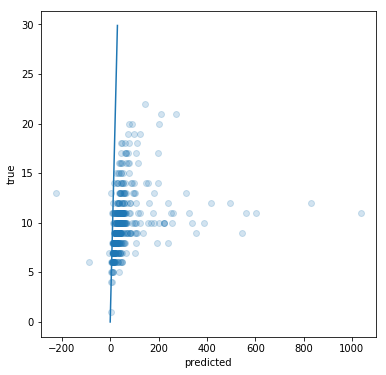

In [287]:
plot_predictions(pred_relu.values().flatten(), y_test)

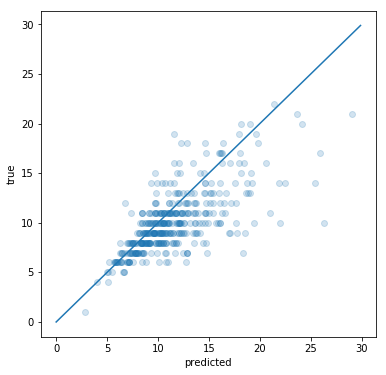

In [288]:
plot_predictions(pred_relu_clear.flatten(), y_test)